In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

import json, argparse
from include.utils import DotDic, plot_learning_curve

from include.DDPG import *
from Environment import Environment

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument("--seed", default=13, type=int)
parser.add_argument("--tau", default=0.005, type=float)  # Target network update rate
parser.add_argument("--gamma", default=0.99, type=float)  # Target network update rate
parser.add_argument('--actor_lr', type=float, default=1e-3)  # learning rate of actor training
parser.add_argument('--critic_lr', type=float, default=2e-2)  # learning rate of critic training
parser.add_argument("--batch_size", default=32, type=int)  # Batch size for both actor and critic
parser.add_argument('--actor_hidden', type=list, default=[512, 256, 128])
parser.add_argument('--critic_hidden', type=list, default=[512, 256, 128])
parser.add_argument('--model_path', type=str, default="./DDPG Training")  # learning rate

parser.add_argument('-c1', '--config_scenario', default='./configs/scenario.json', type=str, help='path to existing scenarionarios file')
args = parser.parse_args(args=[])

if not os.path.exists('%s/' % (args.model_path)):
  os.makedirs('%s/' % (args.model_path))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
scenario = DotDic(json.loads(open(args.config_scenario, 'r').read()))

In [3]:
# Environment action and states
K = scenario.K_t + scenario.K_r
L = scenario.L_t + scenario.L_r

# Actions: (Re{w_k}, Im{w_k}), (Re{u_l}, Im{u_l}), (theta_r, theta_t), rho_l
action_size =   (2 * K * scenario.Nt) + \
                (2 * L * scenario.Nt) + \
                (2 * scenario.R * scenario.Mr) + L

# States:  h, g, h_s, g_s, H, f, STR
state_size =    (scenario.Nt * K) + (scenario.Nt * L) + \
                (scenario.Mr * scenario.R * K) + \
                (scenario.Mr * scenario.R * L) + \
                (scenario.Mr * scenario.Nt * scenario.R) + \
                (L * K) + 1

max_action = 1

print(f'Action space size is: {action_size}, \nState space size is: {state_size}.')

Action space size is: 131, 
State space size is: 434.


In [4]:
# create the environment
env = Environment(scenario, state_size, action_size)
env_test = Environment(scenario, state_size, action_size)

# Create a DDPG instance
agent = DDPG(state_size, action_size, args)
agent_test = DDPG(state_size, action_size, args)

# for reproducibility
# env.set_seed(args.seed)
torch.manual_seed(args.seed)
# np.random.seed(args.seed)

noise_var = 0.1
noise_decay = 0.99993 * max_action

## Train

In [5]:
ep_r = 0
score_hist = []

max_episode = 100
max_steps = 300
trainig_iteration = 32

# Train the agent for max_episodes
for e in range(max_episode):
    done = 0
    total_reward = 0
    state = env.reset()
    # agent.replay_buffer.reset()

    print(f'Training: \n\t episode {e+1}/{max_episode} ...')
    for t in range(max_steps):

        noise_var = noise_var * noise_decay
        exploration_noise = np.random.normal(0, noise_var, size=action_size)

        action = agent.select_action(state)
        action = action + exploration_noise
        action = action.clip(-max_action, max_action)
        
        phi_r, phi_t, rho, w, u = env.action_cal(action)
        next_state, reward, done, info = env.step(phi_r, phi_t, rho, w, u)

        agent.replay_buffer.push((state, next_state, action, reward, done))
        agent.train(trainig_iteration)

        state = next_state
        total_reward += reward

        # print(info['TR'])

        if done:
            print(f'\t done in step {t+1}')
            break
        elif t==max_steps-1:
            print('\t Not done !')
        
    score_hist.append(total_reward)

    print("\t Total Reward: {:0.2f} ".format(total_reward))
    
    
    if e % 100 == 0:
        agent.save()

Training: 
	 episode 1/100 ...
	 Not done !
	 Total Reward: -3061507259.11 
Model has been saved...
Training: 
	 episode 2/100 ...
	 done in step 6
	 Total Reward: -45857590.82 
Training: 
	 episode 3/100 ...
	 done in step 8
	 Total Reward: -69192051.58 
Training: 
	 episode 4/100 ...
	 done in step 3
	 Total Reward: -13066897.75 
Training: 
	 episode 5/100 ...
	 done in step 1
	 Total Reward: 6720247.81 
Training: 
	 episode 6/100 ...
	 done in step 2
	 Total Reward: -1722819.41 
Training: 
	 episode 7/100 ...
	 done in step 12
	 Total Reward: -116373372.26 
Training: 
	 episode 8/100 ...
	 done in step 1
	 Total Reward: 7350922.63 
Training: 
	 episode 9/100 ...
	 done in step 1
	 Total Reward: 6451408.48 
Training: 
	 episode 10/100 ...
	 done in step 5
	 Total Reward: -29528224.93 
Training: 
	 episode 11/100 ...
	 done in step 1
	 Total Reward: 6799458.88 
Training: 
	 episode 12/100 ...
	 done in step 115
	 Total Reward: -1122063793.43 
Training: 
	 episode 13/100 ...
	 done in 

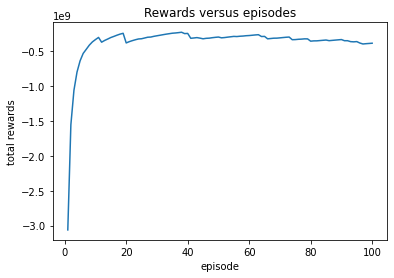

In [6]:
plot_learning_curve(score_hist)

## Test

In [9]:
test_episode = 100
max_steps = 300
score_hist_test = []
agent_test.load()

for e in range(test_episode):
    done = 0
    total_reward = 0
    state = env_test.reset()
    
    print(f'Testing: \n\t episode {e+1}/{test_episode} ...')
    for t in range(max_steps):

        exploration_noise = np.random.normal(0, noise_var, size=action_size)

        action = agent.select_action(state)
        action = action + exploration_noise
        action = action.clip(-max_action, max_action)
        
        phi_r, phi_t, rho, w, u = env_test.action_cal(action)
        next_state, reward, done, info = env_test.step(phi_r, phi_t, rho, w, u)

        state = next_state
        total_reward += reward

        if done:
            print(f'\t done in step {t+1}')
            break
        elif t==max_steps-1:
            print('\t Not done !')
        
    score_hist_test.append(total_reward)

    print("\t Total Reward: {:0.2f} ".format(total_reward))

model has been loaded...
Testing: 
	 episode 1/100 ...
	 Not done !
	 Total Reward: -2803676417.37 
Testing: 
	 episode 2/100 ...
	 done in step 13
	 Total Reward: -105246424.55 
Testing: 
	 episode 3/100 ...
	 done in step 14
	 Total Reward: -122463858.41 
Testing: 
	 episode 4/100 ...
	 done in step 18
	 Total Reward: -150586650.17 
Testing: 
	 episode 5/100 ...
	 done in step 8
	 Total Reward: -55899755.31 
Testing: 
	 episode 6/100 ...
	 done in step 4
	 Total Reward: -18860922.16 
Testing: 
	 episode 7/100 ...
	 done in step 3
	 Total Reward: -9510738.60 
Testing: 
	 episode 8/100 ...
	 done in step 7
	 Total Reward: -60722847.49 
Testing: 
	 episode 9/100 ...
	 done in step 238
	 Total Reward: -1872192821.46 
Testing: 
	 episode 10/100 ...
	 done in step 104
	 Total Reward: -785145460.14 
Testing: 
	 episode 11/100 ...
	 done in step 11
	 Total Reward: -100659352.06 
Testing: 
	 episode 12/100 ...
	 done in step 7
	 Total Reward: -54597312.86 
Testing: 
	 episode 13/100 ...
	 don

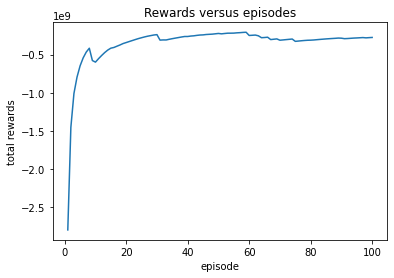

In [10]:
plot_learning_curve(score_hist_test)